This calls calculations from WorkChain


output node list
https://aiida-vasp.readthedocs.io/en/latest/concepts/parsing.html?highlight=trajectory#parsing

In [1]:
import aiida_vasp
print(aiida_vasp.__file__, aiida_vasp.__version__)

/home/max/.virtualenvs/aiida-vasp21/lib/python3.7/site-packages/aiida_vasp/__init__.py 2.1.1


In [81]:
"""
An example call script that performs a single static VASP calculation.

Performs a self consistent electron convergence run using the standard silicon structure.
"""
# pylint: disable=too-many-arguments
import numpy as np
from aiida.common.extendeddicts import AttributeDict
from aiida.orm import Code, Bool, Str
from aiida.plugins import DataFactory, WorkflowFactory
from aiida.engine import submit
from aiida import load_profile
load_profile()


def get_structure():
    """
    Set up Si primitive cell

    Si
       5.431
         0.0000000000000000    0.5000000000000000    0.5000000000000000
         0.5000000000000000    0.0000000000000000    0.5000000000000000
         0.5000000000000000    0.5000000000000000    0.0000000000000000
    Si
       2
    Direct
      0.8750000000000000  0.8750000000000000  0.8750000000000000
      0.1250000000000000  0.1250000000000000  0.1250000000000000

    """

    structure_data = DataFactory('structure')
    alat = 5.431
    lattice = np.array([[.5, 0, .5], [.5, .5, 0], [0, .5, .5]]) * alat
    structure = structure_data(cell=lattice)
    for pos_direct in ([0.875, 0.875, 0.875], [0.125, 0.125, 0.125]):
        pos_cartesian = np.dot(pos_direct, lattice)
        structure.append_atom(position=pos_cartesian, symbols='Si')
    return structure


def main(code_string, incar, kmesh, structure, potential_family, potential_mapping, options):
    """Main method to setup the calculation."""

    # First, we need to fetch the AiiDA datatypes which will
    # house the inputs to our calculation
    dict_data = DataFactory('dict')
    kpoints_data = DataFactory('array.kpoints')

    # Then, we set the workchain you would like to call
    workchain = WorkflowFactory('vasp.vasp')

    # And finally, we declare the options, settings and input containers
    settings = AttributeDict()
    inputs = AttributeDict()

    # Organize settings
    if False:
        # obsolete style
        settings.parser_settings = {'output_params': ['total_energies',
                                        'maximum_force', 'forces']}
    if False:
        # can't get force and trajectory
        print("alternative parser_settings")
        settings.parser_settings = {'misc': True, 'forces': True, 'trajectory': True}
        
    if True:
        # Ref. /home/max/Documents/aiida-vasp/aiida_vasp/parsers/vasp.py
        # DEFAULT_OPTIONS
        parser_settings = {'add_energies': True,
                           'add_dos': True, 
                       'add_forces': True,
                       'add_stress': True,
                       'add_trajectory': True,
                       'add_site_magnetixation': True}
        settings.parser_settings = parser_settings
        settings["ADDITIONAL_RETRIEVE_TEMPORARY_LIST"] = ["IBZKPT"]
        settings["ADDITIONAL_RETRIEVE_LIST"] = ["IBZKPT"]
        
    # Set inputs for the following WorkChain execution
    # Set code
    inputs.code = Code.get_from_string(code_string)
    # Set structure
    inputs.structure = structure
    # Set k-points grid density
    kpoints = kpoints_data()
    kpoints.set_kpoints_mesh(kmesh)
    inputs.kpoints = kpoints
    # Set parameters
    inputs.parameters = dict_data(dict=incar)
    # Set potentials and their mapping
    inputs.potential_family = Str(potential_family)
    inputs.potential_mapping = dict_data(dict=potential_mapping)
    # Set options
    inputs.options = dict_data(dict=options)
    # Set settings
    inputs.settings = dict_data(dict=settings)
    # Set workchain related inputs, in this case, give more explicit output to report
    inputs.verbose = Bool(True)
    # Submit the requested workchain with the supplied inputs
    future = submit(workchain, **inputs)
    print(future)
    return future

if __name__ == '__main__':
    # Code_string is chosen among the list given by 'verdi code list'
    CODE_STRING = 'vasp_iceberg'

    # POSCAR equivalent
    # Set the silicon structure
    STRUCTURE = get_structure()

    # INCAR equivalent
    # Set input parameters
    INCAR = {'incar': {'prec': 'NORMAL', 'encut': 200, 
                       'ediff': 1E-4, 'ialgo': 38, 'ismear': -5, 'sigma': 0.1,
                      'lorbit': 11, # for PDOS 
                      }}

    # KPOINTS equivalent
    # Set kpoint mesh
    KMESH = [9, 9, 9]

    # POTCAR equivalent
    # Potential_family is chosen among the list given by
    # 'verdi data vasp-potcar listfamilies'
    POTENTIAL_FAMILY = 'PBE.54'
    # The potential mapping selects which potential to use, here we use the standard
    # for silicon, this could for instance be {'Si': 'Si_GW'} to use the GW ready
    # potential instead
    POTENTIAL_MAPPING = {'Si': 'Si'}

    # Jobfile equivalent
    # In options, we typically set scheduler options.
    # See https://aiida.readthedocs.io/projects/aiida-core/en/latest/scheduler/index.html
    # AttributeDict is just a special dictionary with the extra benefit that
    # you can set and get the key contents with mydict.mykey, instead of mydict['mykey']
    OPTIONS = AttributeDict()
    OPTIONS.account = ''
    OPTIONS.qos = ''
    OPTIONS.resources = {'num_machines': 1, 'num_mpiprocs_per_machine': 3}
    OPTIONS.queue_name = ''
    OPTIONS.max_wallclock_seconds = 3600
    OPTIONS.max_memory_kb = 10240000

    workchain = main(CODE_STRING, INCAR, KMESH, STRUCTURE, POTENTIAL_FAMILY, POTENTIAL_MAPPING, OPTIONS)

uuid: cc6c8c00-30ad-4624-a36f-046de5af92b3 (pk: 1910) (aiida.workflows:vasp.vasp)


In [82]:
from aiida.orm.nodes.process.calculation.calcjob import CalcJobNode
import time
waitsec =  5
future = None
while future is None:
    for node in workchain.get_outgoing().all_nodes():
        if isinstance(node,CalcJobNode):
            print(node)
            future = node
            break
    time.sleep(waitsec)

uuid: 9e30f513-a253-4051-b680-b432fdf5272b (pk: 1912) (aiida.calculations:vasp.vasp)


In [83]:
import time
waitsec =  5
while not future.is_terminated:
    print("exception %s, sleep %d sec" % (future.exception, waitsec))
    time.sleep(waitsec)
print("finished_ok",future.is_finished_ok)
print("exit_message", future.exit_message)

exception None, sleep 5 sec
exception None, sleep 5 sec
exception None, sleep 5 sec
exception None, sleep 5 sec
exception None, sleep 5 sec
exception None, sleep 5 sec
exception None, sleep 5 sec
exception None, sleep 5 sec
finished_ok True
exit_message the sun is shining


1912
Info: Initiating graphviz engine: dot
Info: Recursing ancestors, max depth=None
Info: Recursing descendants, max depth=None
Success: Output file: 1912.dot.pdf


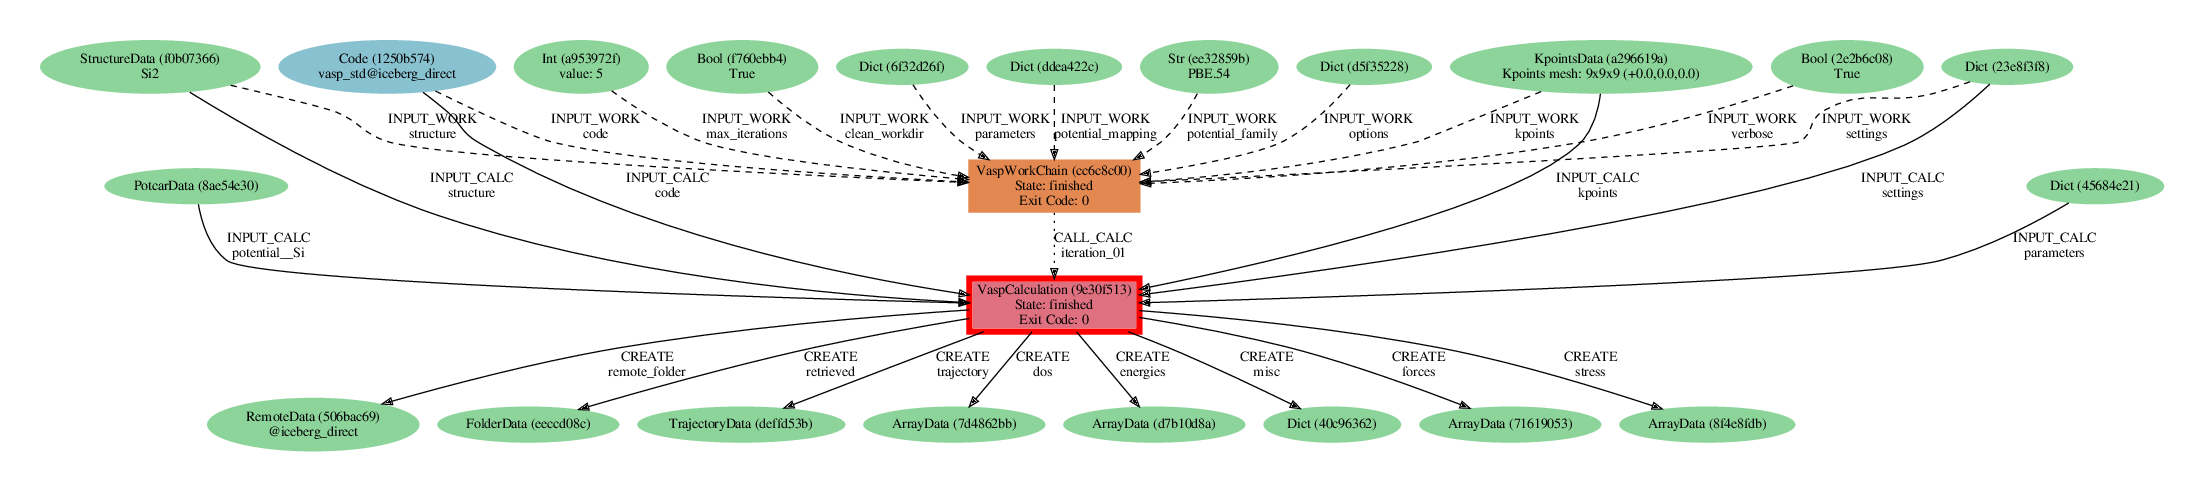

In [84]:
pk = future.pk
print(pk)
import subprocess
cmd = "verdi node graph generate {}".format(pk)
subprocess.call(cmd,shell=True)

from wand.image import Image as WImage
WImage(filename="{}.dot.pdf".format(pk))

In [85]:
workchain.outputs.misc.attributes

{'version': '6.1.2',
 'run_stats': {'user_time': 0.907,
  'system_time': 0.045,
  'elapsed_time': 0.966,
  'mem_usage_base': 30000.0,
  'mem_usage_grid': 507.0,
  'mem_usage_wavefun': 488.0,
  'mem_usage_fftplans': 284.0,
  'average_memory_used': 0.0,
  'maximum_memory_used': 41040.0,
  'mem_usage_nonl-proj': 620.0,
  'total_cpu_time_used': 0.952,
  'mem_usage_one-center': 6.0},
 'run_status': {'nsw': 0,
  'nelm': 60,
  'ibrion': -1,
  'finished': True,
  'ionic_converged': None,
  'contains_nelm_breach': False,
  'electronic_converged': True,
  'last_iteration_index': [1, 10],
  'consistent_nelm_breach': False},
 'magnetization': [],
 'maximum_force': 0.0,
 'notifications': [],
 'maximum_stress': 17.90960765,
 'total_energies': {'energy_extrapolated': -10.79613733}}

In [86]:
workchain.outputs.energies.get_array("energy_extrapolated")

array([-10.79613733])

In [87]:
workchain.outputs.stress.get_array('final')

array([[17.90960765, -0.        ,  0.        ],
       [-0.        , 17.90960765, -0.        ],
       [ 0.        ,  0.        , 17.90960765]])

In [88]:
workchain.outputs.forces.get_array("final")

array([[ 0.,  0., -0.],
       [-0., -0.,  0.]])

In [89]:
workchain.outputs.trajectory.attributes

{'symbols': ['Si', 'Si'],
 'array|cells': [2, 3, 3],
 'array|steps': [2],
 'array|forces': [2, 2, 3],
 'array|stress': [2, 3, 3],
 'array|positions': [2, 2, 3]}

In [90]:
workchain.outputs.trajectory.get_array('cells')

array([[[2.7155, 0.    , 2.7155],
        [2.7155, 2.7155, 0.    ],
        [0.    , 2.7155, 2.7155]],

       [[2.7155, 0.    , 2.7155],
        [2.7155, 2.7155, 0.    ],
        [0.    , 2.7155, 2.7155]]])

In [91]:
workchain.outputs.trajectory.get_array('steps')

array([0, 1])

In [92]:
workchain.outputs.trajectory.get_array('forces')

array([[[ 0.,  0., -0.],
        [-0., -0.,  0.]],

       [[ 0.,  0., -0.],
        [-0., -0.,  0.]]])

In [93]:
workchain.outputs.trajectory.get_array('positions')

array([[[0.875, 0.875, 0.875],
        [0.125, 0.125, 0.125]],

       [[0.875, 0.875, 0.875],
        [0.125, 0.125, 0.125]]])

In [94]:
workchain.outputs.dos.attributes

{'array|pdos': [2, 301, 9], 'array|tdos': [301], 'array|energy': [301]}

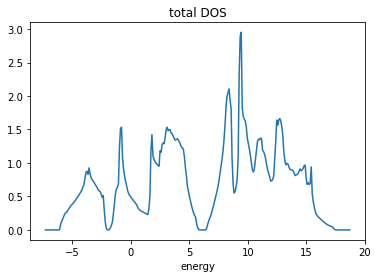

In [95]:
def outputs_dos_plot(dos):
    energy = dos.get_array("energy")
    tdos = dos.get_array("tdos")

    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    ax.plot(energy,tdos)
    ax.set_xlabel("energy")
    ax.set_title("total DOS")
outputs_dos_plot(workchain.outputs.dos)

In [1]:
def outputs_pdos_plot(dos):
    energy = dos.get_array("energy")
    pdos = dos.get_array("pdos")

    import numpy as np
    import matplotlib.pyplot as plt
    for i in range(pdos.shape[0]):
        fig, ax = plt.subplots()
        ax.plot(energy,pdos[i,:,0], label="s")
        ax.plot(energy,np.sum(pdos[i,:,1:4], axis=1), label="p")
        ax.plot(energy,np.sum(pdos[i,:,4:], axis=1), label="d")
        ax.legend()
        ax.set_xlabel("energy")
        ax.set_title("site %d" % i)
        
outputs_pdos_plot(workchain.outputs.dos)

NameError: name 'workchain' is not defined

## 結果ファイルの取得

In [97]:
from getnodefile import CopyInputOutputFiles

In [98]:
pk = future.pk
! verdi calcjob inputls $pk

.aiida
INCAR
KPOINTS
POSCAR
_aiidasubmit.sh


In [99]:
! verdi calcjob outputls $pk

CONTCAR
DOSCAR
EIGENVAL
IBZKPT
OUTCAR
_scheduler-stderr.txt
_scheduler-stdout.txt
vasp_output
vasprun.xml


In [124]:
pk

1912

In [130]:
copyvaspio = CopyInputOutputFiles(["INCAR","KPOINTS","POSCAR"],
                                  ["CONTCAR","OUTCAR","DOSCAR","IBZKPT","vasprun.xml"])
dirname = "VASP_RESULT_{}".format(pk)
import os
if not os.path.isdir(dirname):
    os.mkdir(dirname)
copyvaspio.copy(future, dirname)

0

In [132]:
print(dirname)
! ls -l $dirname

VASP_RESULT_1912
total 404
-rw-r--r-- 1 max users    512 Aug  2 11:25 CONTCAR
-rw-r--r-- 1 max users  83453 Aug  2 11:25 DOSCAR
-rw-r--r-- 1 max users   8589 Aug  2 11:25 IBZKPT
-rw-r--r-- 1 max users     88 Aug  2 11:25 INCAR
-rw-r--r-- 1 max users    105 Aug  2 11:25 KPOINTS
-rw-r--r-- 1 max users  72472 Aug  2 11:25 OUTCAR
-rw-r--r-- 1 max users    290 Aug  2 11:25 POSCAR
-rw-r--r-- 1 max users 224788 Aug  2 11:25 vasprun.xml


pymatgenのDoscarはDOS取得に失敗する。

In [104]:
from pymatgen.io.lobster.outputs import Doscar
filedoscar = os.path.join(dirname,"DOSCAR")
fileposcar = os.path.join(dirname,"CONTCAR")
doscar = Doscar(filedoscar, fileposcar)

IndexError: list index out of range

上のコードはエラーが起きて実行できない。

ではaseでDOSが取得できるか？
aseは最新版をinstallし直すこと！

In [142]:
!pwd
# os.chdir("/home/max/Documents/aiida_primer_v2/10.vasp")
# os.chdir("..")

/home/max/Documents/aiida_primer_v2/10.vasp


In [143]:
from ase.dft.dos import DOS
from ase.calculators.vasp import Vasp
import ase
print(ase.__file__, ase.__version__)
direc = 'VASP_RESULT_{}'.format(pk)
print(direc)

calc = Vasp(restart=False, directory=direc)
calc.read_results()
energies, dos = calc.get_dos() 
os.chdir("..")

# こちらもバグっている。
# FileNotFoundError: [Errno 2] No such file or directory: 'VASP_RESULT_1786/VASP_RESULT_1786/IBZKPT'

# or
# --> 558         xml_results['forces'] = xml_results['forces'][self.resort]
# AttributeError: 'Vasp' object has no attribute 'resort'


/home/max/.virtualenvs/aiida-vasp21/lib/python3.7/site-packages/ase/__init__.py 3.23.0b1
VASP_RESULT_1912


AttributeError: 'Vasp' object has no attribute 'resort'

再び次を実行する。

In [140]:
!pwd

/home/max/Documents/aiida_primer_v2/10.vasp


In [139]:
from pymatgen.io.vasp.outputs import Outcar

filepath = os.path.join(dirname, "OUTCAR")
outcar = Outcar(filepath)
print("charge",outcar.charge)
print("magnetization", outcar.magnetization)
print("is_stopped", outcar.is_stopped)

outcar.as_dict()

charge ({'s': 0.761, 'p': 0.969, 'd': 0.0, 'tot': 1.729}, {'s': 0.761, 'p': 0.969, 'd': 0.0, 'tot': 1.729})
magnetization ()
is_stopped False


{'@module': 'pymatgen.io.vasp.outputs',
 '@class': 'Outcar',
 'efermi': 5.8499,
 'run_stats': {'Average memory used (kb)': 0.0,
  'Maximum memory used (kb)': 41040.0,
  'Elapsed time (sec)': 0.966,
  'System time (sec)': 0.045,
  'User time (sec)': 0.907,
  'Total CPU time used (sec)': 0.952,
  'cores': '3'},
 'magnetization': (),
 'charge': ({'s': 0.761, 'p': 0.969, 'd': 0.0, 'tot': 1.729},
  {'s': 0.761, 'p': 0.969, 'd': 0.0, 'tot': 1.729}),
 'total_magnetization': None,
 'nelect': 8.0,
 'is_stopped': False,
 'drift': [[-0.0, 0.0, -0.0]],
 'ngf': [28, 28, 28],
 'sampling_radii': [0.9892],
 'electrostatic_potential': [-83.2549, -83.2549],
 'onsite_density_matrices': []}

## vasprun.xmlを用いたデータ取得

In [27]:
from pymatgen.io.lobster.outputs import Vasprun
filepath = os.path.join(dirname,"vasprun.xml", )
vasprun = Vasprun(filepath, parse_dos=True)

/home/max/.virtualenvs/aiida-vasp21/lib/python3.7/site-packages/pymatgen/io/vasp/outputs.py:1053: UserWarning: No POTCAR file with matching TITEL fields was found in /home/max/Documents/aiida_primer_v2/10.vasp/VASP_RESULT_1849
  " was found in {}".format(os.path.abspath(p))


In [28]:
vasprun.calculate_efermi(), vasprun.final_energy

(5.84991039, -10.79613733)

In [29]:
vasprun.converged, vasprun.converged_ionic

(True, True)

In [30]:
vasprun.dos_has_errors

False

In [31]:
vasprun.tdos.as_dict().keys()

dict_keys(['@module', '@class', 'efermi', 'energies', 'densities'])

In [32]:
x = vasprun.tdos.as_dict()["energies"] # list
y = vasprun.tdos.as_dict()["densities"] # dict
y.keys()

dict_keys(['1'])

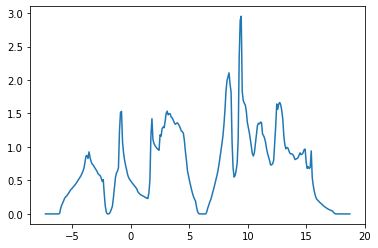

In [33]:
import matplotlib.pyplot as plt
plt.plot(x,y['1'])